In [45]:
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import ARDRegression

In [60]:
data = pd.read_csv('../data/men_velodata2.csv')
data['day'].replace(0, 1, inplace = True)
data.insert(
    4, 'date', [
        date(year = int(data.loc[i, 'year']), month = int(data.loc[i, 'month']), day = int(data.loc[i, 'day']))
        for i in data.index
    ]
)
data.drop(columns = ['year', 'month', 'day'], inplace = True)
data.head(5)

,name,stage,points_scale,parcours_type,date,type,length,profile_score,avg_speed,vertical_meters,won_how,place,rider,team,age,time
0,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,1.0,ALAPHILIPPE Julian,Deceuninck - Quick Step,29.0,0.0
1,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,2.0,MATTHEWS Michael,Team BikeExchange,30.0,8.0
2,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,3.0,ROGLIČ Primož,Team Jumbo-Visma,31.0,8.0
3,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,4.0,HAIG Jack,Bahrain - Victorious,27.0,8.0
4,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,5.0,KELDERMAN Wilco,BORA - hansgrohe,30.0,8.0


In [54]:
def get_rider_data(data, rider):
    
    rider_data = data[data['rider'] == rider].sort_values(by = ['year', 'month', 'day']).reset_index(drop = True)
    return rider_data

In [55]:
def mvavg(seq, window = 5):
    return [
        np.mean(seq[i - window: i])
        for i in range(window, len(seq))
    ]

def auto(seq, window = 5):
    
    X = [
        seq[i - window: i]
        for i in range(window, len(seq))
    ]
    y = list(seq[window: ])
    
    model = ARDRegression()
    model.fit(X, y)
    
    return model.predict(X)

In [56]:
[ala_x[i - 5: i] for i in range(5, len(ala_x))]

[[datetime.date(2012, 5, 26),
  datetime.date(2012, 8, 19),
  datetime.date(2013, 6, 23),
  datetime.date(2013, 6, 23),
  datetime.date(2013, 7, 12)],
 [datetime.date(2012, 8, 19),
  datetime.date(2013, 6, 23),
  datetime.date(2013, 6, 23),
  datetime.date(2013, 7, 12),
  datetime.date(2013, 7, 13)],
 [datetime.date(2013, 6, 23),
  datetime.date(2013, 6, 23),
  datetime.date(2013, 7, 12),
  datetime.date(2013, 7, 13),
  datetime.date(2013, 7, 14)],
 [datetime.date(2013, 6, 23),
  datetime.date(2013, 7, 12),
  datetime.date(2013, 7, 13),
  datetime.date(2013, 7, 14),
  datetime.date(2013, 7, 14)],
 [datetime.date(2013, 7, 12),
  datetime.date(2013, 7, 13),
  datetime.date(2013, 7, 14),
  datetime.date(2013, 7, 14),
  datetime.date(2013, 8, 9)],
 [datetime.date(2013, 7, 13),
  datetime.date(2013, 7, 14),
  datetime.date(2013, 7, 14),
  datetime.date(2013, 8, 9),
  datetime.date(2013, 8, 10)],
 [datetime.date(2013, 7, 14),
  datetime.date(2013, 7, 14),
  datetime.date(2013, 8, 9),
  datet

In [57]:
ala_data = get_rider_data(data, 'ALAPHILIPPE Julian')
ala_x = [
    date(
        year = int(ala_data.loc[i, 'year']),
        month = int(ala_data.loc[i, 'month']),
        day = int(ala_data.loc[i, 'day'])
    )
    for i in ala_data.index
]
ala_y = ala_data['place']

sagan_data = get_rider_data(data, 'SAGAN Peter')
sagan_x = [
    date(
        year = int(sagan_data.loc[i, 'year']),
        month = int(sagan_data.loc[i, 'month']),
        day = int(sagan_data.loc[i, 'day'])
    )
    for i in sagan_data.index
]
sagan_y = sagan_data['place']

In [58]:
def plot_rider_results(data, name, window = 12):
    
    athlete_data = get_rider_data(data, name)
    x = [
        date(
            year = int(athlete_data.loc[i, 'year']),
            month = int(athlete_data.loc[i, 'month']),
            day = int(athlete_data.loc[i, 'day'])
        )
        for i in athlete_data.index
    ]
    y = athlete_data['place']
    
    
    fig, ax = plt.subplots(figsize = (16, 12))
    ax.scatter(x, y, color = 'black')
    ax.scatter(x[window: ], auto(y, window = window), color = 'blue')
    ax.invert_yaxis()

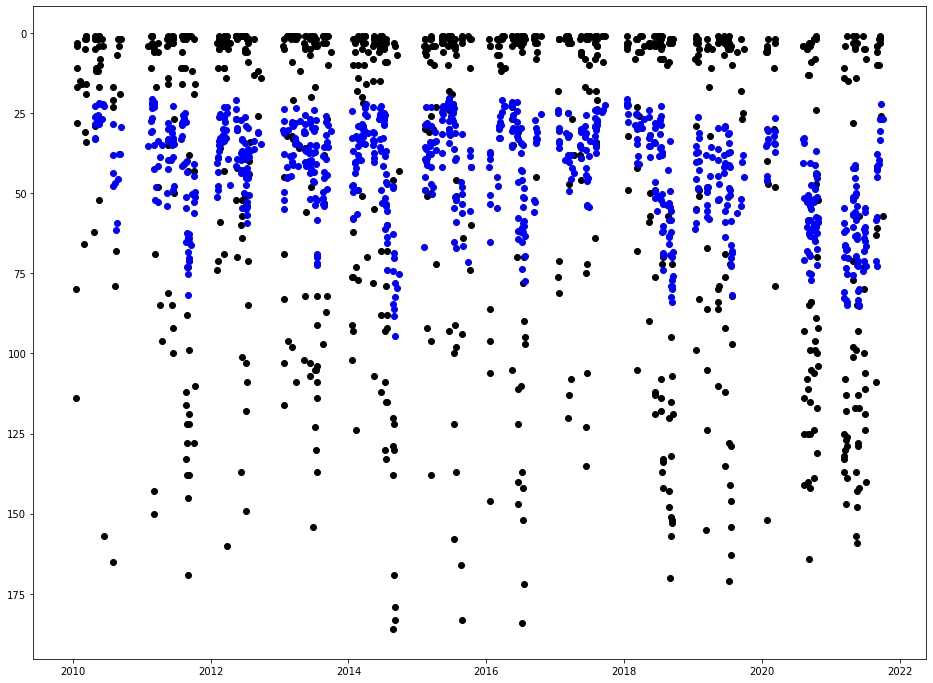

In [59]:
plot_rider_results(data, 'SAGAN Peter', window = 20)

In [ ]:
def 